## Ex-04

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,TensorDataset

### Task 1

#### 1.1

<div style="color: green; font-weight: bold"> <li>Has implemented SIR setup function with all necessary parameters and return values.</li>
</div>

In [2]:
def simulate_sir_simple(lam, mu, I0, T, N):
    X = [] # observations
    C = [] # states

    I = I0 # number of infected individuals
    R = 0 # number of recovered individuals
    S = N - I - R # number of susceptible individuals

    for t in range(T):
        C.append((S, I, R))

        dS = -lam * S * I / N
        dI = lam * S * I / N - (mu * I)
        dR = mu * I

        # for T+1
        S_next = S + dS
        I_next = I + dI
        R_next = R + dR

        dS = S - S_next
        dR = R_next - R

        X.append((dS, dR))

        S,I,R = S_next, I_next, R_next
    
    return np.array(X), np.array(C)

#### 1.2

<div style="color: green; font-weight: bold"> <li>Has provided visualization for checking the effect of different parameters for the simulate_sir_sample function.</li>
<div style="color: green; font-weight: bold"> <li>Also checked with t = 100 and given the necessary conclusions and best parameters.</li>

</div>

In [3]:
def explore_prior(N, T, lam_list, mu_list, I0_list):
    fig, axes = plt.subplots(len(lam_list), len(mu_list), figsize=(15, 15), sharex=True, sharey=True)
    for i, lam in enumerate(lam_list):
        for j, mu in enumerate(mu_list):
            for I0 in I0_list:
                _, states = simulate_sir_simple(lam, mu, I0, T, N)
                
                S,I,R = zip(*states)
                S, I, R = np.array(S), np.array(I), np.array(R)

                ax=axes[i, j]
                ax.plot(range(T), S, label=f'S(t), I0={I0}')
                ax.plot(range(T), I, label=f'I(t), I0={I0}')
                ax.plot(range(T), R, label=f'R(t), I0={I0}')
                ax.set_title(f'λ={lam}, μ={mu}')
                ax.set_xlabel('days')
                ax.set_ylabel('population')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(I0_list))
    plt.tight_layout()
    plt.show()

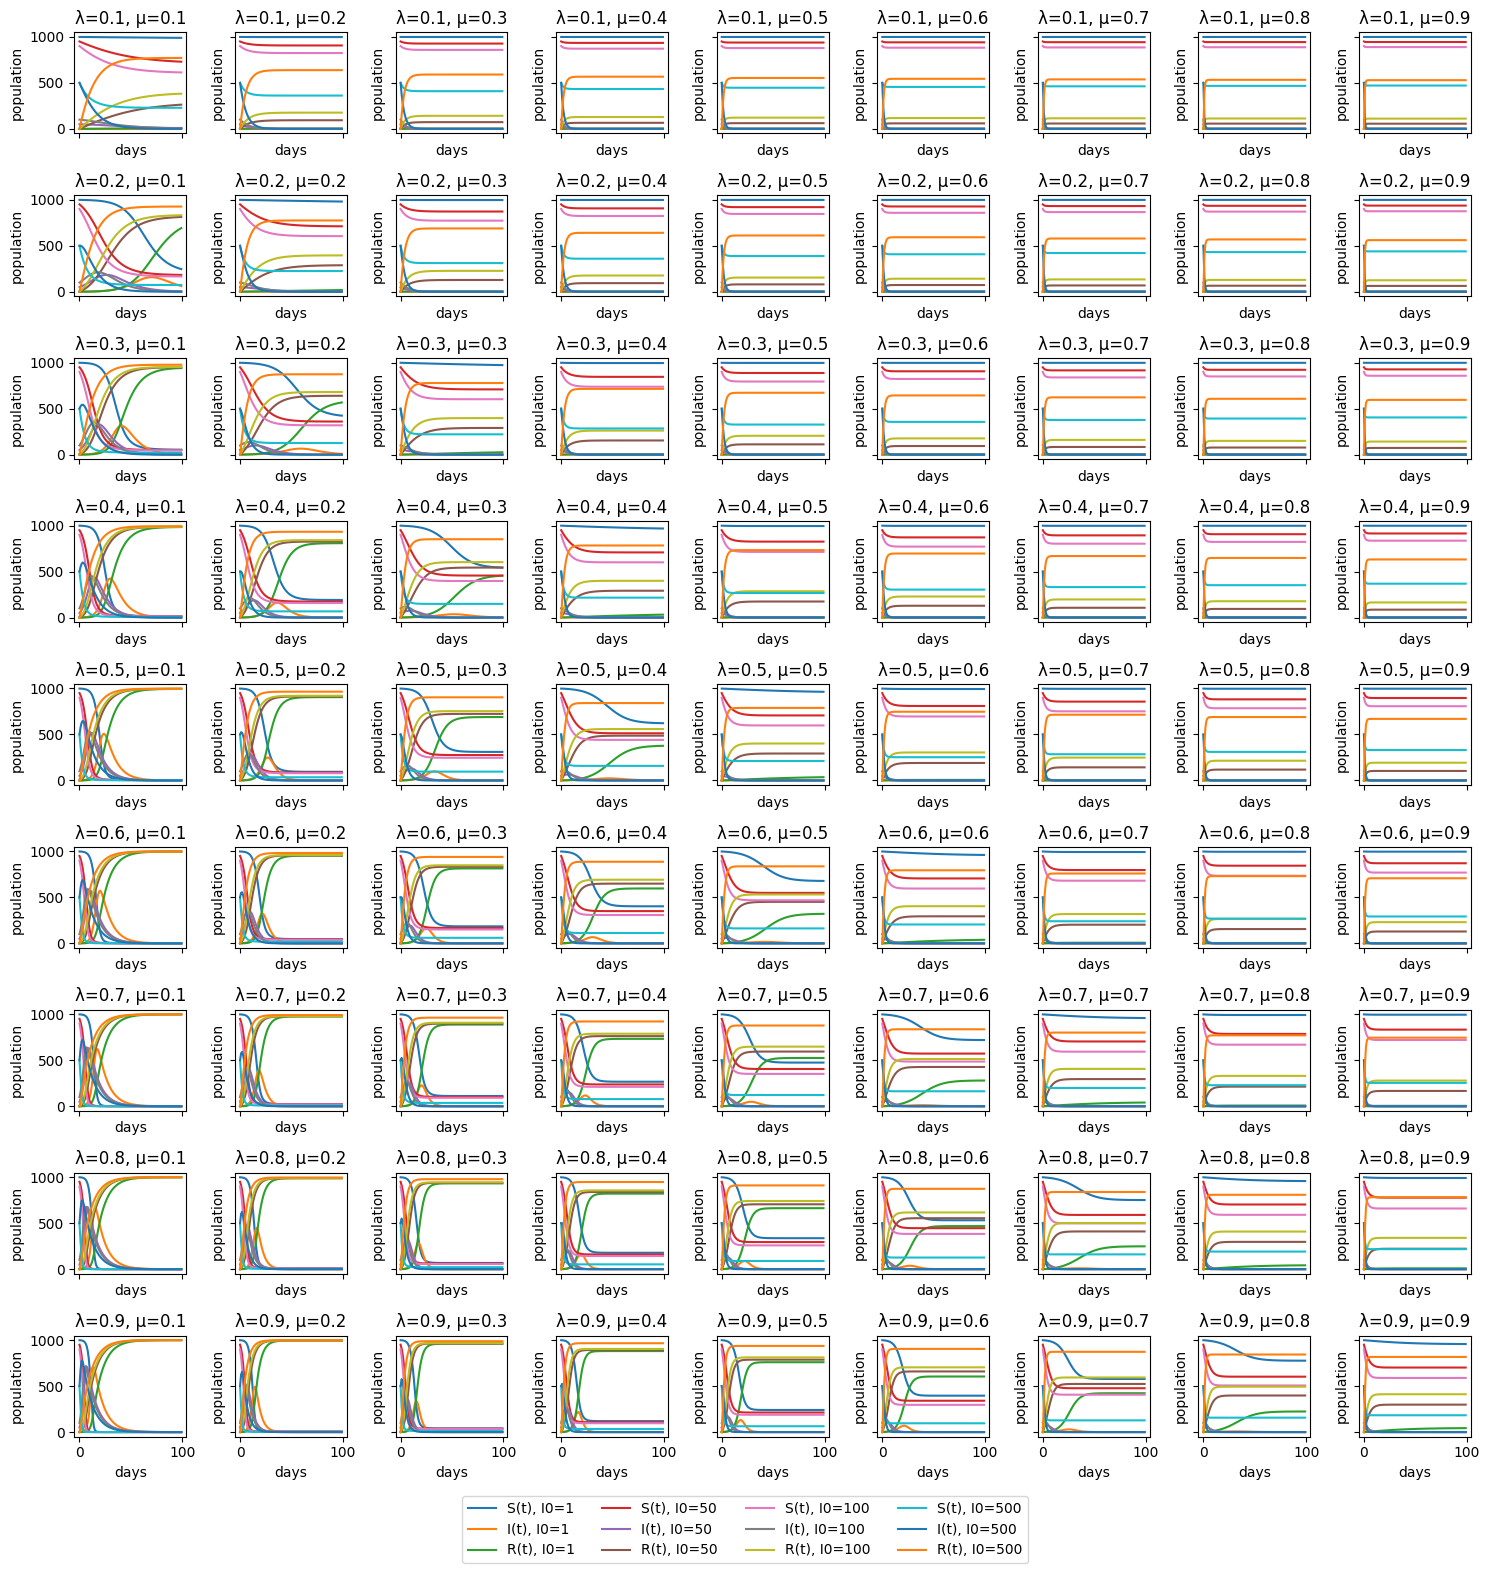

In [4]:
N = 1000
T = 100

# hyperparameters
lam_list = np.round(np.linspace(0.1, 0.9, 9),1)
mu_list = np.round(np.linspace(0.1, 0.9, 9),1)
I0_list =  [1, 50, 100, 500]

explore_prior(N, T, lam_list, mu_list, I0_list)



With range
* lambda = [0.2, 0.9]
* mu = [0.1, 0.7]
* I_0 = [1, 100]
  
the most diverse dynamics are observed.

#### 1.3

<div style="color: green; font-weight: bold"> <li>Has implemented the SIRModel with Feed Forward Neural network instead of CNN as provided in the sample solution.</li>
<li> Has provided necessary train, test functions and visualization for the SIRModel.</li>

</div>

In [5]:
def generate_sir_data(num_samples, T, N):
    data = []
    target = []

    for _ in range(num_samples):
        lam = np.random.uniform(0.2, 0.9)
        mu = np.random.uniform(0.1, 0.7)
        I0 = np.random.randint(1,100)

        X, _ = simulate_sir_simple(lam, mu, I0, T, N)

        data.append(X.flatten())
        target.append([lam, mu, I0])

    return np.array(data), np.array(target)

class SIRDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]
    
class SIRModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SIRModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [6]:
def train_model(model, criterion, optimizer, data_loader, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()
            
            output = model(x_batch)
            
            loss = criterion(output, y_batch)
            loss.backward()
            
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss/len(data_loader))
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}')
    return losses

def test_model(model, dataloader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            outputs = model(x_batch)

            preds.append(np.array(outputs))
            targets.append(np.array(y_batch))
    
    return np.vstack(preds), np.vstack(targets)

<div style="color: green; font-weight: bold"> <li>Missing necessary conclusions and inferences from the outputs.</li>
<li>Has plotted the target and predicted values for the test data.</li>
</div>

Training mode ...
Epoch 1/50, Loss: 241.9659
Epoch 6/50, Loss: 8.5415
Epoch 11/50, Loss: 2.2789
Epoch 16/50, Loss: 0.5541
Epoch 21/50, Loss: 0.2494
Epoch 26/50, Loss: 0.4930
Epoch 31/50, Loss: 0.3878
Epoch 36/50, Loss: 0.2304
Epoch 41/50, Loss: 0.5943
Epoch 46/50, Loss: 0.5427


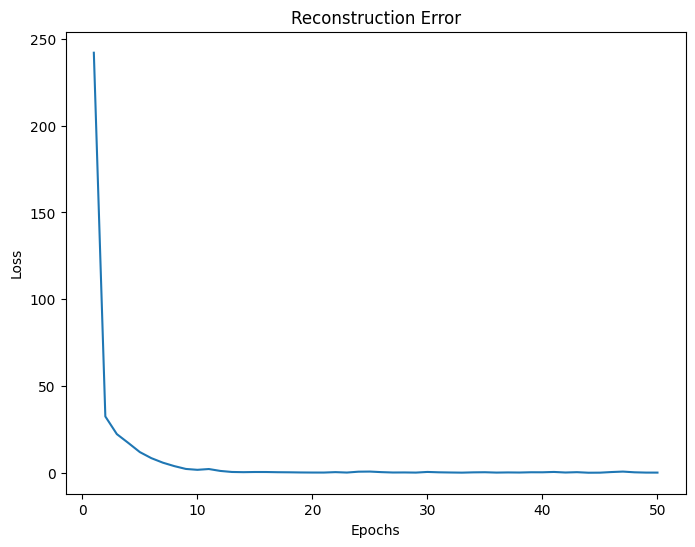

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/4015364856.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/4015364856.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


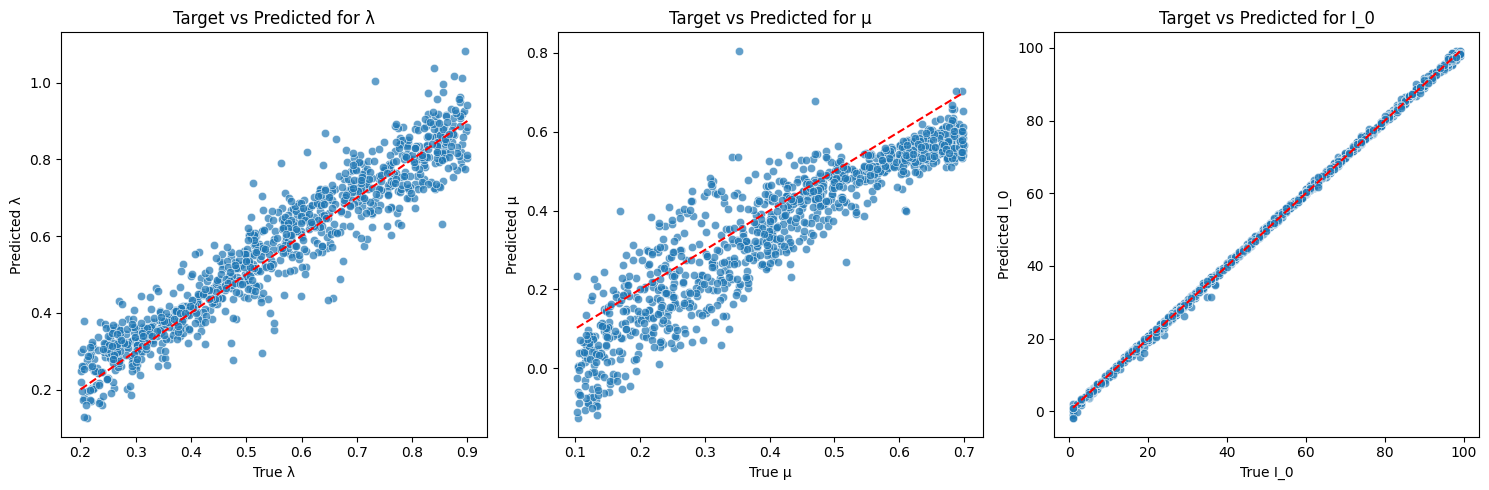

In [7]:
# hyperparameters
N = 1000
T = 100
num_samples = 5000
test_samples = 1000
input_size = T*2 # flattened SIR
hidden_size = 128
output_size = 3 # [lam, mu, I0]
batch_size = 64
lr = 0.001
epochs = 50

# generate data
x_train, y_train = generate_sir_data(num_samples, T, N)
x_test, y_test = generate_sir_data(num_samples=test_samples, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initialize model
model = SIRModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train model
print('Training mode ...')
train_loss = train_model(model, criterion, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

#test model
print('Test mode ...')
preds, targets = test_model(model, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, param in enumerate(cols):
        sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
        axes[i].plot([target_df[param].min(), target_df[param].max()],
                     [target_df[param].min(), target_df[param].max()],
                     color='red', linestyle='--')
        axes[i].set_xlabel(f'True {param}')
        axes[i].set_ylabel(f'Predicted {param}')
        axes[i].set_title(f'Target vs Predicted for {param}')
plt.tight_layout()
plt.show()


#### 1.4

<div style="color: green; font-weight: bold"> <li>Has implemented the Conditional RealNVP with necessary changes.</li>

</div>

In [8]:
# Conditional realNVP components
class ConditionalCouplingLayer(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size):
        super(ConditionalCouplingLayer, self).__init__()
        self.split1 = input_size // 2
        self.split2 = input_size - self.split1

        self.subnet = nn.Sequential(
            nn.Linear(self.split1 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2 * self.split2),
        )

    def forward(self, x, cond):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], dim=-1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)

        log_jacob_det = torch.sum(s, dim=-1)

        x2 = torch.exp(s) * x2 + t
        return torch.cat([x1, x2], dim=-1), log_jacob_det


    def reverse(self, x, cond):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]
        params = self.subnet(torch.cat([x1, cond], dim=-1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)

        x2 = (x2 - t) * torch.exp(-s)
        return torch.cat([x1, x2], dim=-1)

class ConditionalrealNVP(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size, n_layers):
        super(ConditionalrealNVP, self).__init__()
        self.layers = nn.ModuleList([
            ConditionalCouplingLayer(input_size, condition_size, hidden_size) for _ in range(n_layers)
        ])

    def forward(self, x, context):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x, context)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def reverse(self, z, context):
        for layer in reversed(self.layers):
            z = layer.reverse(z, context)
        return z

In [9]:
def train_realNVP(feature_extractor, realNVP, optimizer, data_loader, epochs):
    feature_extractor.train()
    realNVP.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()

            context = feature_extractor(x_batch)
            z, log_det_jacobian = realNVP(y_batch, context)
            
            nll = 0.5 * torch.sum(z**2, dim=1) - log_det_jacobian
            loss = torch.mean(nll)
            loss.backward()
            
            optimizer.step()
            epoch_loss += loss.item()
        
        losses.append(epoch_loss/len(data_loader))

        if epoch % 2 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}')
    
    return np.array(losses)

def test_realNVP(feature_extractor, realNVP, data_loader):
    feature_extractor.eval()
    realNVP.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            context = feature_extractor(x_batch)
            outputs = realNVP.reverse(torch.randn_like(y_batch), context)

            preds.append(np.array(outputs))
            targets.append(np.array(y_batch))
    
    return np.vstack(preds), np.vstack(targets)


<div style="color: green; font-weight: bold"> <li>Has provided the posterior results and visualizations.</li>
<li>But missing necessary inferences.</li>

</div>

Training mode ...
Epoch 1/50, Loss: 63.7104
Epoch 3/50, Loss: 1.4205
Epoch 5/50, Loss: 1.0354
Epoch 7/50, Loss: 0.6610
Epoch 9/50, Loss: 0.4803
Epoch 11/50, Loss: -0.0064
Epoch 13/50, Loss: 0.0158
Epoch 15/50, Loss: -0.2190
Epoch 17/50, Loss: -0.0612
Epoch 19/50, Loss: 0.0826
Epoch 21/50, Loss: -0.4647
Epoch 23/50, Loss: -0.0404
Epoch 25/50, Loss: 0.2591
Epoch 27/50, Loss: -0.4760
Epoch 29/50, Loss: -0.1908
Epoch 31/50, Loss: -0.2632
Epoch 33/50, Loss: 0.4863
Epoch 35/50, Loss: 0.2263
Epoch 37/50, Loss: -0.0194
Epoch 39/50, Loss: -0.1643
Epoch 41/50, Loss: -0.1991
Epoch 43/50, Loss: -0.1115
Epoch 45/50, Loss: 0.2068
Epoch 47/50, Loss: -0.3333
Epoch 49/50, Loss: -0.3454


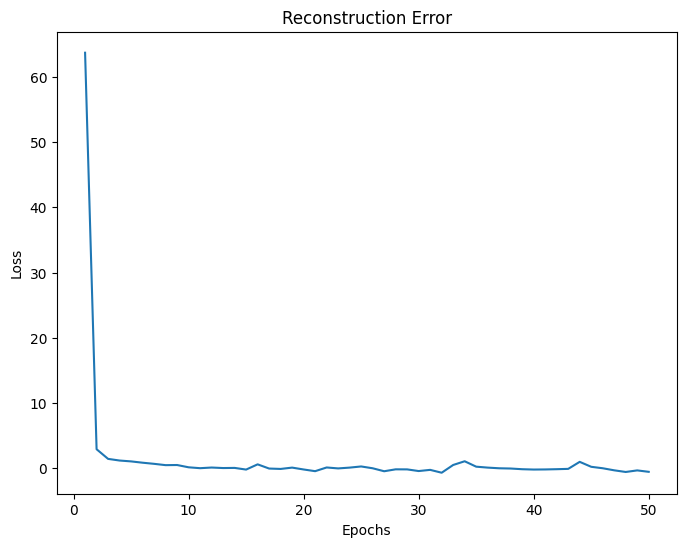

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/443406207.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/443406207.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


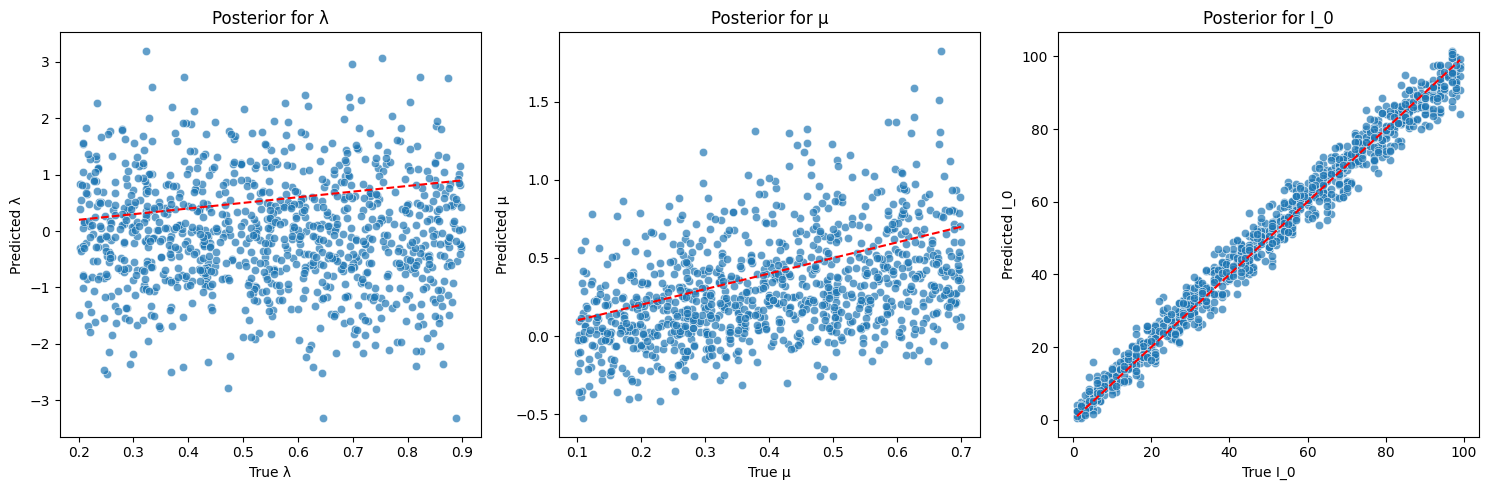

In [10]:
# Hyperparameters
T = 100
N = 1000
num_samples = 5000
test_samples = 1000
input_size = T*2 # Flattened (dS, dR)
hidden_size = 64
batch_size = 64
lr = 0.001
epochs = 50
n_layers=2


# generate data
x_train, y_train = generate_sir_data(num_samples, T, N)
x_test, y_test = generate_sir_data(num_samples=test_samples, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize feature extractor and realNVP
feature_extractor = SIRModel(input_size, hidden_size, hidden_size)
realNVP = ConditionalrealNVP(input_size=3, condition_size=hidden_size, hidden_size=hidden_size, n_layers=n_layers)

# Define optimizer
params = list(feature_extractor.parameters()) + list(realNVP.parameters())
optimizer = optim.Adam(params, lr=lr)

# train model
print('Training mode ...')
train_loss = train_realNVP(feature_extractor, realNVP, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

# test model
print('Test mode ...')
preds, targets = test_realNVP(feature_extractor, realNVP, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, param in enumerate(cols):
    sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
    axes[i].plot([target_df[param].min(), target_df[param].max()],
                 [target_df[param].min(), target_df[param].max()],
                 color='red', linestyle='--')
    axes[i].set_xlabel(f'True {param}')
    axes[i].set_ylabel(f'Predicted {param}')
    axes[i].set_title(f'Posterior for {param}')
plt.tight_layout()
plt.show()


#### 1.5

<div style="color: green; font-weight: bold"> <li>Has provided visualization for the marginal and joint distribution estimates on the test data.</li>
<div style="color: green; font-weight: bold"> <li>Provided functions for generating posterior sample data, computing energy (as given in the question), .</li>
<li>Missing inferences or conclusions.</li>
</div>

In [11]:
def generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds, input_size):

    feature_extractor.eval()
    realNVP.eval()

    all_samples = []
    all_targets = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(next(feature_extractor.parameters()).device)
            context = feature_extractor(x)

            samples = []
            for _ in range(num_preds):
                z = torch.randn((x.size(0), input_size), device=context.device)  # Sampling from prior
                sample = realNVP.reverse(z, context)
                samples.append(sample.cpu().numpy())

            all_samples.append(np.stack(samples, axis=0))
            all_targets.append(y.numpy())

    preds = np.concatenate(all_samples, axis=1)  # Shape: (M, len(test_data), num_params)
    targets = np.concatenate(all_targets, axis=0)  # Shape: (len(test_data), num_params)

    return preds, targets

def compute_energy(y_samples, targets):
    
    targets = targets[None, :, :]  # Broadcast for M samples
    energy = -0.5 * np.sum((y_samples - targets) ** 2, axis=-1)  # Gaussian assumption
    return energy

def plot_posterior_distributions(samples, params):

    fig, axes = plt.subplots(2, len(params), figsize=(15, 5))
    for i, param in enumerate(params):
        param_samples = samples[:, :, i].flatten()

        axes[0,i].hist(param_samples, bins=30, density=True, alpha=0.5, label='Posterior Samples')
        axes[0,i].set_title(f'Posterior Histogram - {param}')
        axes[0,i].set_xlabel('Value')
        axes[0,i].set_ylabel('Density')
        axes[0,i].legend()

        # Empirical CDF
        ecdf = np.sort(param_samples)
        axes[1,i].plot(ecdf, np.linspace(0, 1, len(ecdf)), label='Empirical CDF', lw=2)
        axes[1,i].set_title(f'Empirical CDF - {param}')
        axes[1,i].set_xlabel('Value')
        axes[1,i].set_ylabel('Cumulative Probability')
        axes[1,i].legend()

    plt.tight_layout()
    plt.show()

def plot_joint_distribution(samples, params):

    joint_samples = samples.reshape(-1, samples.shape[-1])  # Shape: (M * len(X), num_params)
    df = pd.DataFrame(joint_samples, columns=params)

    sns.pairplot(df, diag_kind='kde', plot_kws={'s': 1, 'alpha':0.5}, corner=True)
    plt.suptitle('Joint Posterior Distribution', y=1)
    plt.show()

Mean Energy Score: -8.0579
Standard Deviation of Energy Scores: 11.5818


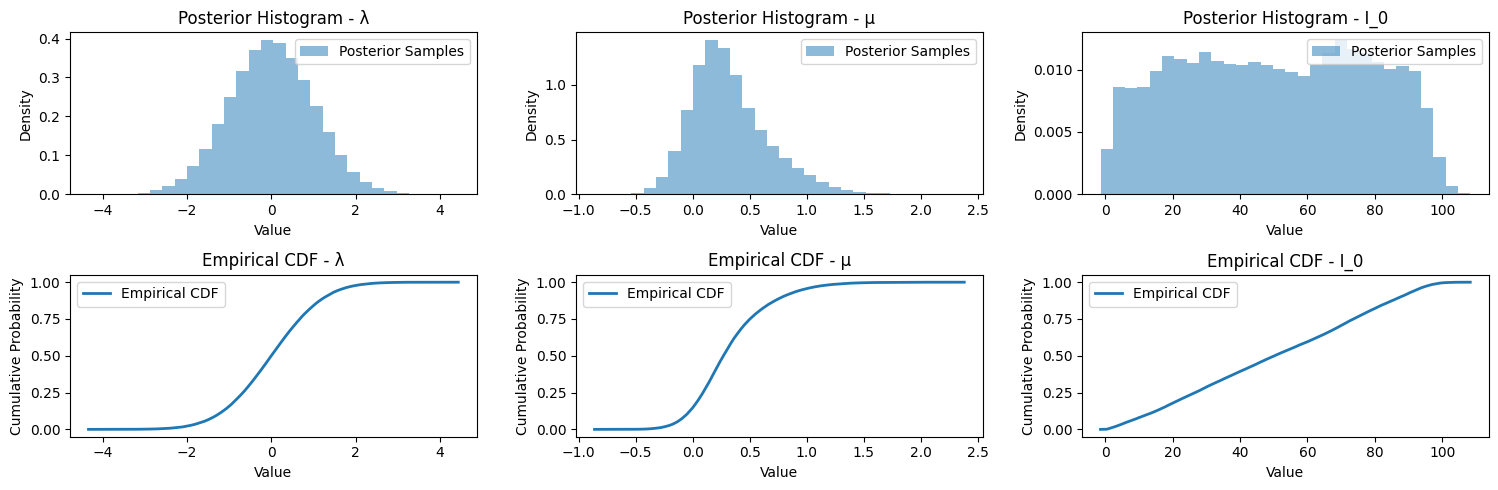

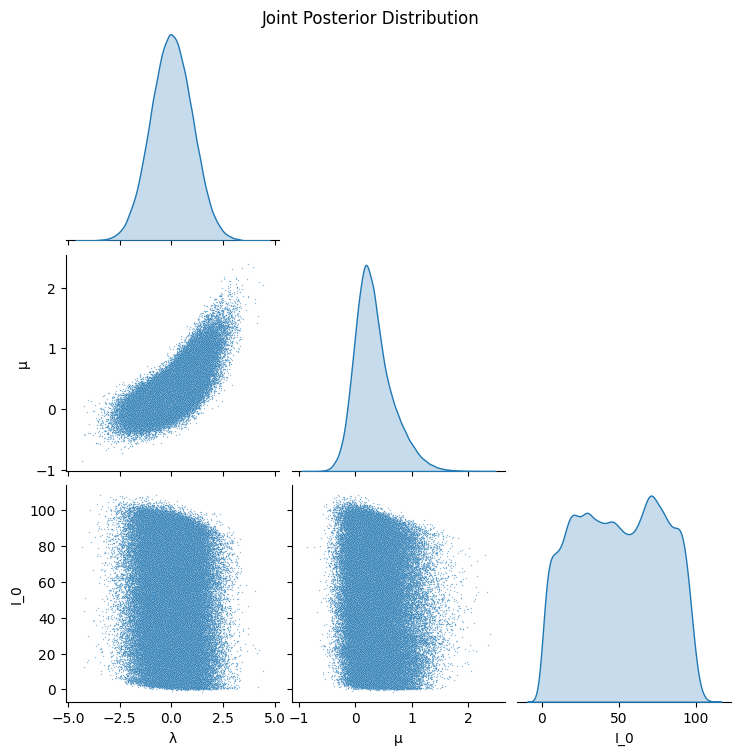

In [12]:
num_preds = 100
input_size = 3
params = ['λ', 'μ', 'I_0']

preds, targets = generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds, input_size)

energy_scores = compute_energy(preds, targets)

# displaying summarized energy scores
print(f'Mean Energy Score: {np.mean(energy_scores):.4f}')
print(f'Standard Deviation of Energy Scores: {np.std(energy_scores):.4f}')

# marginal distributions
plot_posterior_distributions(preds, params)

# joint distributions
plot_joint_distribution(preds, params)


### 1.6

<div style="color: green; font-weight: bold"> <li>Missing comments on the findings </li>
<li>Has provided a plot for posterior predictive calibration.</li>
</div>

In [13]:
def plot_confidence_intervals(resimulated_outcomes, true_simulated_outcomes, coverage):

    lower_bound = np.percentile(resimulated_outcomes, 2.5, axis=0)
    upper_bound = np.percentile(resimulated_outcomes, 97.5, axis=0)
    
    params = ['dS', 'dR']

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    for i, param in enumerate(params):
        axes[i].fill_between(range(len(lower_bound)), lower_bound[:, i], upper_bound[:, i], color='skyblue', alpha=0.5, label='95% CI')
        axes[i].plot(true_simulated_outcomes[:, i], 'o', color='orange', label='True Outcomes')
        axes[i].set_xlabel('samples')
        axes[i].set_ylabel(f'{param}')
        axes[i].legend()
    plt.suptitle(f'Posterior Predictive Calibration with coverage = {coverage}')
    plt.tight_layout()
    plt.show()

In [14]:
def posterior_predictive_calibration(posterior_samples, simulate_sir_simple, true_outcomes, T, N):

    M = posterior_samples.shape[0]

    resimulated_outcomes = []

    # simulate outcomes for predicted samples
    for k in range(M):
        current_outcomes = []
        for lam, mu, I0 in posterior_samples[k]:
            X, _ = simulate_sir_simple(lam, mu, I0, T, N)
            current_outcomes.append(np.sum(X, axis=0))
        resimulated_outcomes.append(np.stack(current_outcomes, axis=0))

    resimulated_outcomes = np.stack(resimulated_outcomes, axis=0)

    # simulate outcomes for true samples
    true_simulated_outcomes = []
    for lam, mu, I0 in true_outcomes:
        X, _ = simulate_sir_simple(lam, mu, I0, T, N)
        true_simulated_outcomes.append(np.sum(X, axis=0))

    true_simulated_outcomes = np.stack(true_simulated_outcomes, axis=0)

    # confidence intervals from predicted simulations
    lower_bound = np.percentile(resimulated_outcomes, 2.5, axis=0)
    upper_bound = np.percentile(resimulated_outcomes, 97.5, axis=0)

    # Check if true simulated outcomes are within confidence intervals
    true_within_interval = np.logical_and(true_simulated_outcomes >= lower_bound, true_simulated_outcomes <= upper_bound)

    # coverage as the proportion of observations within intervals
    coverage = np.mean(np.all(true_within_interval, axis=1))

    plot_confidence_intervals(resimulated_outcomes, true_simulated_outcomes, coverage)
    
    
    return coverage


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/1062177979.py:12: RuntimeWarning: overflow encountered in scalar multiply
  dS = -lam * S * I / N
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/1062177979.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dI = lam * S * I / N - (mu * I)
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/1062177979.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  dS = S - S_next
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/1062177979.py:22: RuntimeWarning: invalid value encountered in scalar subtract
  dR = R_next - R
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/1062177979.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  dI = lam * S * I / N - (mu * I)
/Users/sandrinjoy/Desktop/Dacs/gnns-ws-24/.conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4623: RuntimeWarning: invalid value encountered in 

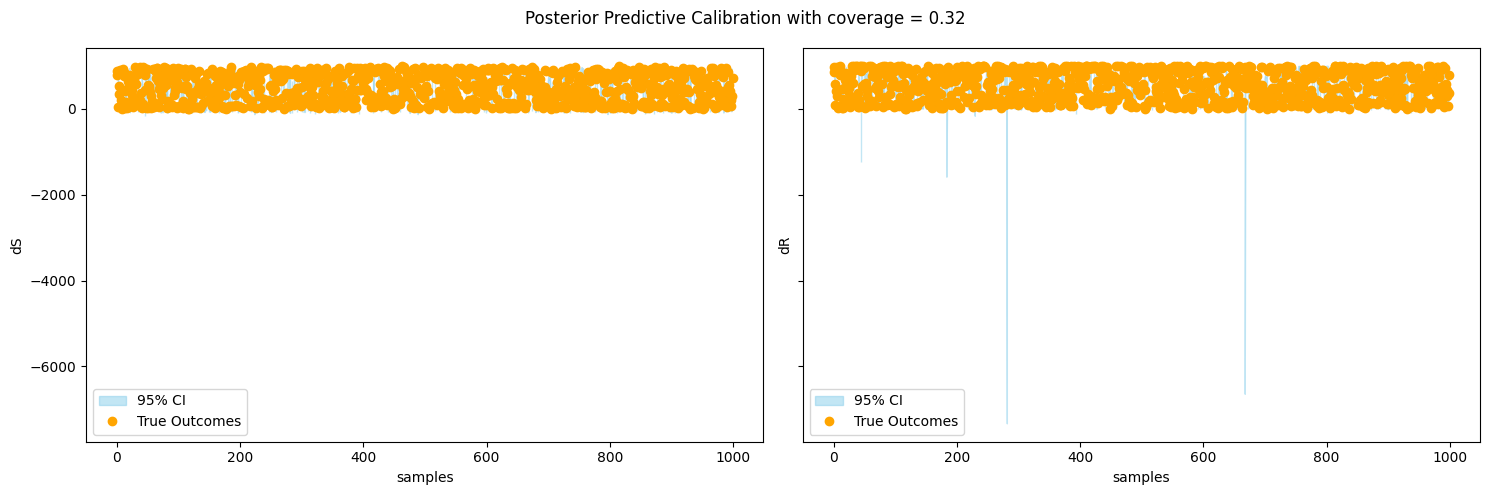

np.float64(0.32)

In [15]:
posterior_predictive_calibration(preds, simulate_sir_simple, y_test, T, N)


### Task 2

#### 2.1

<div style="color: green; font-weight: bold"> <li>Has implemented noisy simulation with necessary modifications as needed.</li>
<li>As in the sample solution, the noise is multiplicative gaussian noise.</li>

</div>

In [16]:
import numpy as np

def simulate_sir_noisy(lam, mu, I0, L, rho, sigma2, T, N):

    X, C = simulate_sir_simple(lam, mu, I0, T, N)

    # multiplicative Gaussian noise
    ep_S = np.random.normal(rho, np.sqrt(sigma2), T)
    ep_I = np.random.normal(rho, np.sqrt(sigma2), T)
    ep_R = np.random.normal(rho, np.sqrt(sigma2), T)

    dS, dR = X[:, 0]*ep_S, X[:, 1]*ep_R
    S, I, R = C[:,0]*ep_S, C[:,1]*ep_I, C[:,2]*ep_R

    X = np.stack([dS, dR], axis=1)
    C = np.stack([S, I, R], axis=1)

    X_shifted = np.roll(X, int(L), axis=0)
    C_shifted = np.roll(C, int(L), axis=0)

    return X_shifted, C_shifted


In [17]:
def explore_noisy_prior(lam, mu, I0, N, T, L_list, rho_list, sigma_list):
    fig, axes = plt.subplots(len(rho_list), len(sigma_list), figsize=(15, 15), sharex=True, sharey=True)
    for i, rho in enumerate(rho_list):
        for j, sigma2 in enumerate(sigma_list):
            for L in L_list:
                sim, _ = simulate_sir_noisy(lam, mu, I0, L, rho, sigma2, T, N)
                
                S, R = zip(*sim)
                S, R = np.array(S), np.array(R)

                ax=axes[i, j]
                ax.plot(range(T), S, label=f'S(t), L={L}', linewidth=0.5)
                ax.plot(range(T), R, label=f'R(t), L={L}', linewidth=0.5)
                ax.set_title(f'ρ={rho}, σ2={sigma2}')
                ax.set_xlabel('days')
                ax.set_ylabel('value')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(L_list))
    plt.tight_layout()
    plt.show()


In [18]:
lam=0.4
mu=0.2
I0=1
N = 1000
T = 100

# hyperparameters
rho_list = np.round(np.linspace(0.1, 0.9, 9), 1)
sigma_list = np.round(np.linspace(0.1, 0.9, 9), 1)
L_list =  np.linspace(0, 10, 2)

<div style="color: green; font-weight: bold"> <li>After adding noise, we have again added the visualisations and provided the most affective parameters for the prior data.</li>

</div>

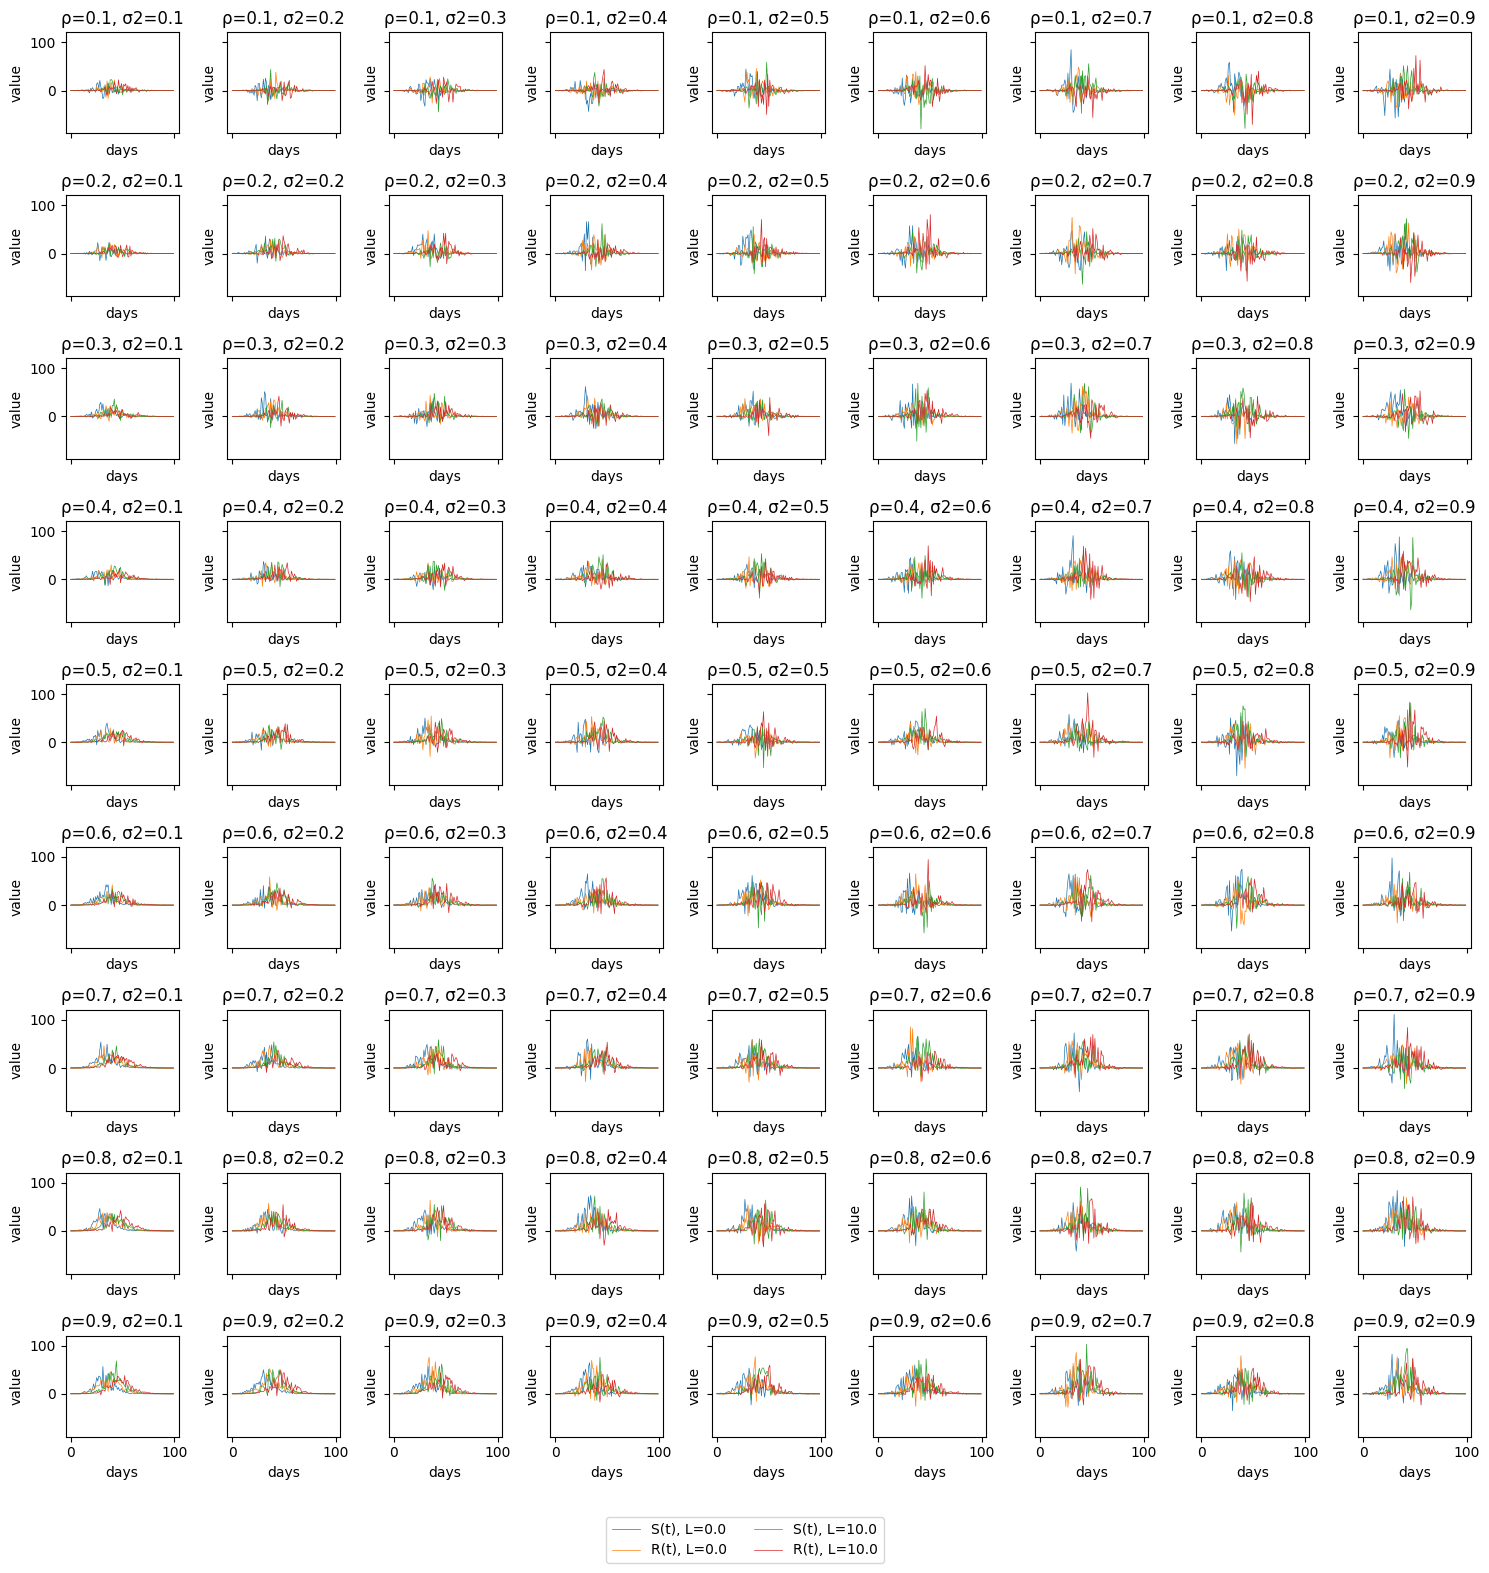

In [19]:
explore_noisy_prior(lam, mu, I0, N, T, L_list, rho_list, sigma_list)

The picked ranges are
* rho = [0.1, 0.9]
* sigma = [0.3, 0.9]
* L = [1, 10]
  
the most diverse dynamics are observed.

<div style="color: green; font-weight: bold"> <li>Has implemented noisy data generation with random parameters and provided targetted vs predicted graph for the same.</li>

</div>

In [20]:
def generate_noisy_sir_data(num_samples, lam, mu, I0, T, N):
    data = []
    target = []

    for _ in range(num_samples):
        rho = np.random.uniform(0.1, 0.9)
        sigma2 = np.random.uniform(0.3, 0.9)
        L = np.random.randint(1,10)

        X, _ = simulate_sir_noisy(lam, mu, I0, L, rho, sigma2, T, N)

        data.append(X.flatten())
        target.append([lam, mu, I0, rho, sigma2, L])

    return np.array(data), np.array(target)



Training mode ...
Epoch 1/50, Loss: 1.0963
Epoch 6/50, Loss: 0.1832
Epoch 11/50, Loss: 0.0823
Epoch 16/50, Loss: 0.0445
Epoch 21/50, Loss: 0.0410
Epoch 26/50, Loss: 0.0318
Epoch 31/50, Loss: 0.0170
Epoch 36/50, Loss: 0.0182
Epoch 41/50, Loss: 0.0278
Epoch 46/50, Loss: 0.0166


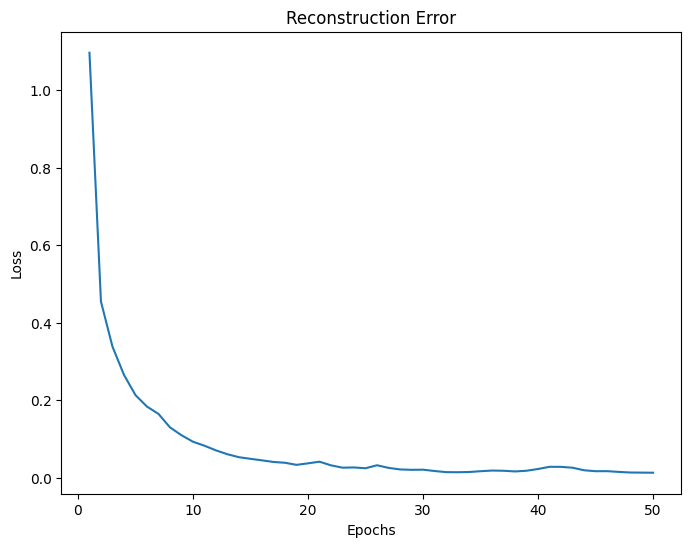

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/4015364856.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/4015364856.py:31: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


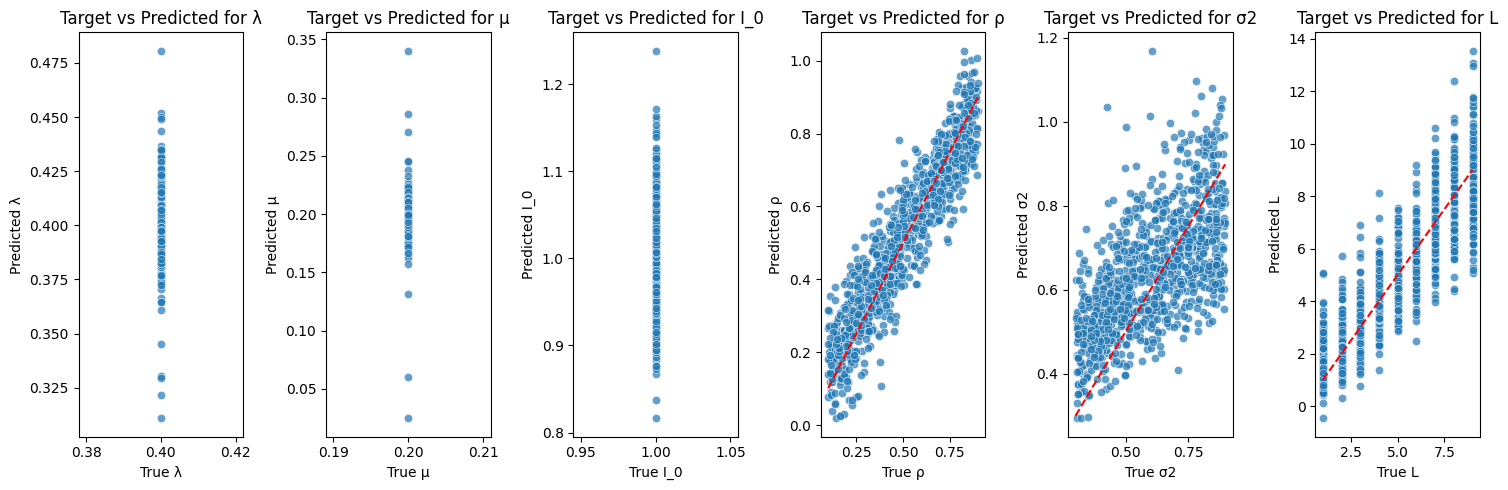

In [21]:
# hyperparameters
lam=0.4
mu=0.2
I0=1
N = 1000
T = 100
num_samples = 5000
test_samples = 1000
input_size = T*2 # flattened SIR
hidden_size = 128
output_size = 6 # [lam, mu, I0, rho, sigma2, L]
batch_size = 64
lr = 0.001
epochs = 50

# generate data
x_train, y_train = generate_noisy_sir_data(num_samples, lam, mu, I0, T, N)
x_test, y_test = generate_noisy_sir_data(num_samples=test_samples, lam=lam, mu=mu, I0=I0, T=T, N=N)

# preprocess data
train_dataset = SIRDataset(x_train, y_train)
test_dataset = SIRDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initialize model
model = SIRModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# train model
print('Training mode ...')
train_loss = train_model(model, criterion, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

#test model
print('Test mode ...')
preds, targets = test_model(model, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0', 'ρ', 'σ2', 'L']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, len(cols), figsize=(15,5))
for i, param in enumerate(cols):
        sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
        axes[i].plot([target_df[param].min(), target_df[param].max()],
                     [target_df[param].min(), target_df[param].max()],
                     color='red', linestyle='--')
        axes[i].set_xlabel(f'True {param}')
        axes[i].set_ylabel(f'Predicted {param}')
        axes[i].set_title(f'Target vs Predicted for {param}')
plt.tight_layout()
plt.show()


<div style="color: green; font-weight: bold"> <li>Has done other necessary functionalities from TASK 1 for this task as well but with noise.</li>
<li> But missing necessary inferences or conclusions.</li>

</div>

Conditional RealNVP

Training mode ...
Epoch 1/100, Loss: -0.0467
Epoch 3/100, Loss: -0.8726
Epoch 5/100, Loss: -2.1709
Epoch 7/100, Loss: -2.5259
Epoch 9/100, Loss: -2.7570
Epoch 11/100, Loss: -2.9374
Epoch 13/100, Loss: -3.0440
Epoch 15/100, Loss: -3.1015
Epoch 17/100, Loss: -3.1921
Epoch 19/100, Loss: -3.2565
Epoch 21/100, Loss: -3.2594
Epoch 23/100, Loss: -3.4279
Epoch 25/100, Loss: -3.5185
Epoch 27/100, Loss: -3.0727
Epoch 29/100, Loss: -3.6016
Epoch 31/100, Loss: -3.6795
Epoch 33/100, Loss: -3.6779
Epoch 35/100, Loss: -3.8543
Epoch 37/100, Loss: -3.8682
Epoch 39/100, Loss: -3.9784
Epoch 41/100, Loss: -3.9048
Epoch 43/100, Loss: -4.0113
Epoch 45/100, Loss: -4.0743
Epoch 47/100, Loss: -4.1614
Epoch 49/100, Loss: -4.1267
Epoch 51/100, Loss: -4.1703
Epoch 53/100, Loss: -4.2428
Epoch 55/100, Loss: -4.1957
Epoch 57/100, Loss: -4.2576
Epoch 59/100, Loss: -4.1049
Epoch 61/100, Loss: -4.1215
Epoch 63/100, Loss: -4.2626
Epoch 65/100, Loss: -4.3307
Epoch 67/100, Loss: -4.3653
Epoch 69/100, Loss: -4.4095
Epoch 7

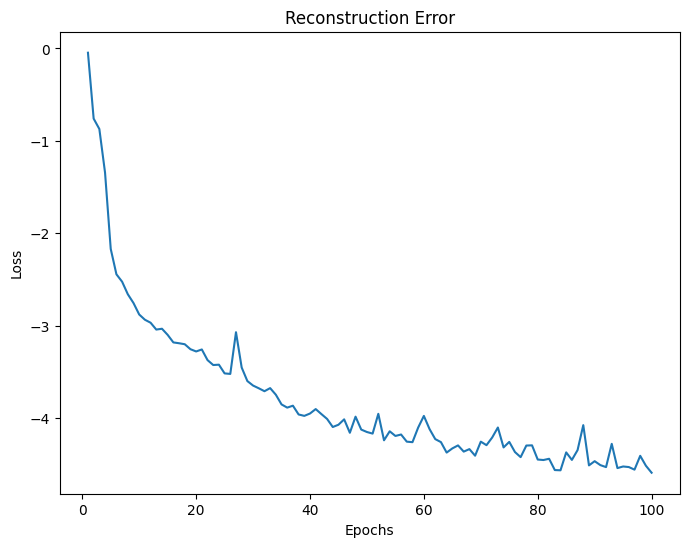

Test mode ...


/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/443406207.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  preds.append(np.array(outputs))
/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_47538/443406207.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  targets.append(np.array(y_batch))


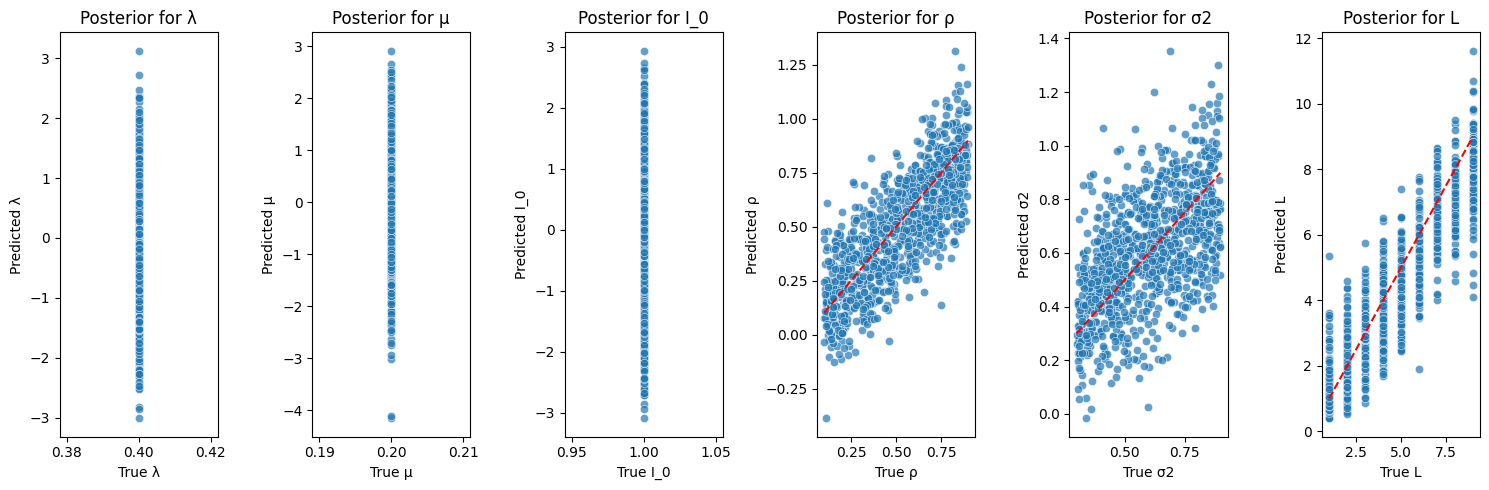

In [22]:
# Hyperparameters
input_size = T*2 # Flattened (dS, dR)
hidden_size = 128
batch_size = 64
lr = 0.001
epochs = 100
n_layers=2

# Initialize feature extractor and realNVP
feature_extractor = SIRModel(input_size, hidden_size, hidden_size)
realNVP = ConditionalrealNVP(input_size=6, condition_size=hidden_size, hidden_size=hidden_size, n_layers=n_layers)

# Define optimizer
params = list(feature_extractor.parameters()) + list(realNVP.parameters())
optimizer = optim.Adam(params, lr=lr)

# train model
print('Training mode ...')
train_loss = train_realNVP(feature_extractor, realNVP, optimizer, train_loader, epochs)

# visualize training loss
plt.figure(figsize=(8,6))
sns.lineplot(x=np.arange(1, epochs+1), y=train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Error')
plt.show()

# test model
print('Test mode ...')
preds, targets = test_realNVP(feature_extractor, realNVP, test_loader)

# visualize predictions vs targets
cols = ['λ', 'μ', 'I_0', 'ρ', 'σ2', 'L']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, len(cols), figsize=(15,5))
for i, param in enumerate(cols):
    sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
    axes[i].plot([target_df[param].min(), target_df[param].max()],
                 [target_df[param].min(), target_df[param].max()],
                 color='red', linestyle='--')
    axes[i].set_xlabel(f'True {param}')
    axes[i].set_ylabel(f'Predicted {param}')
    axes[i].set_title(f'Posterior for {param}')
plt.tight_layout()
plt.show()


posterior distributions

Mean Energy Score: -2.7437
Standard Deviation of Energy Scores: 2.0943


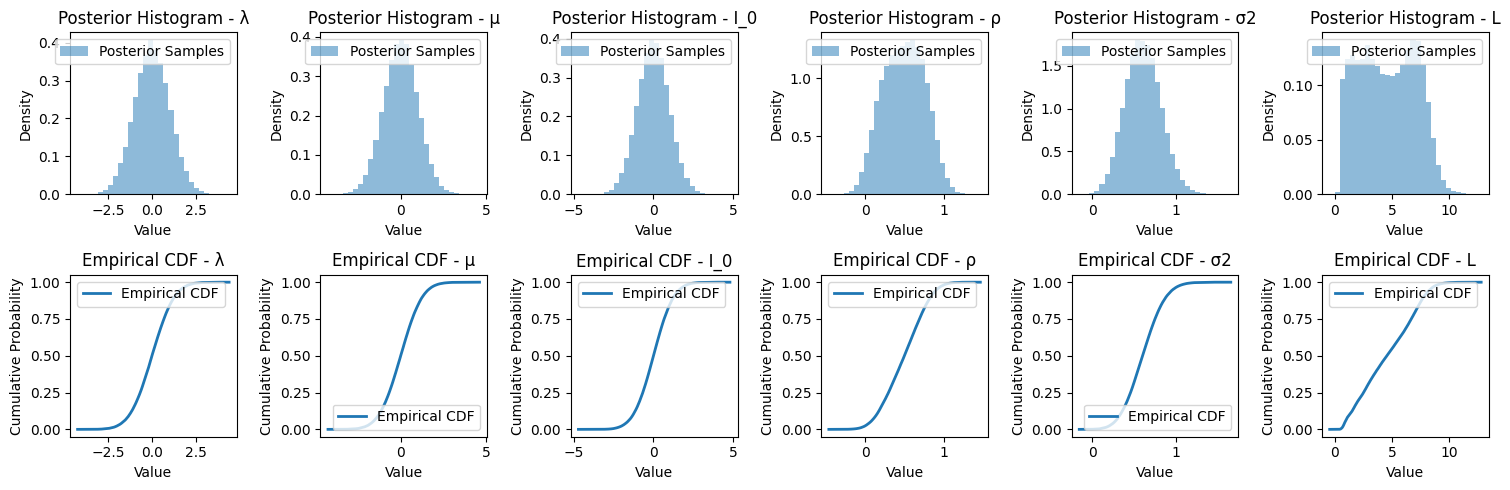

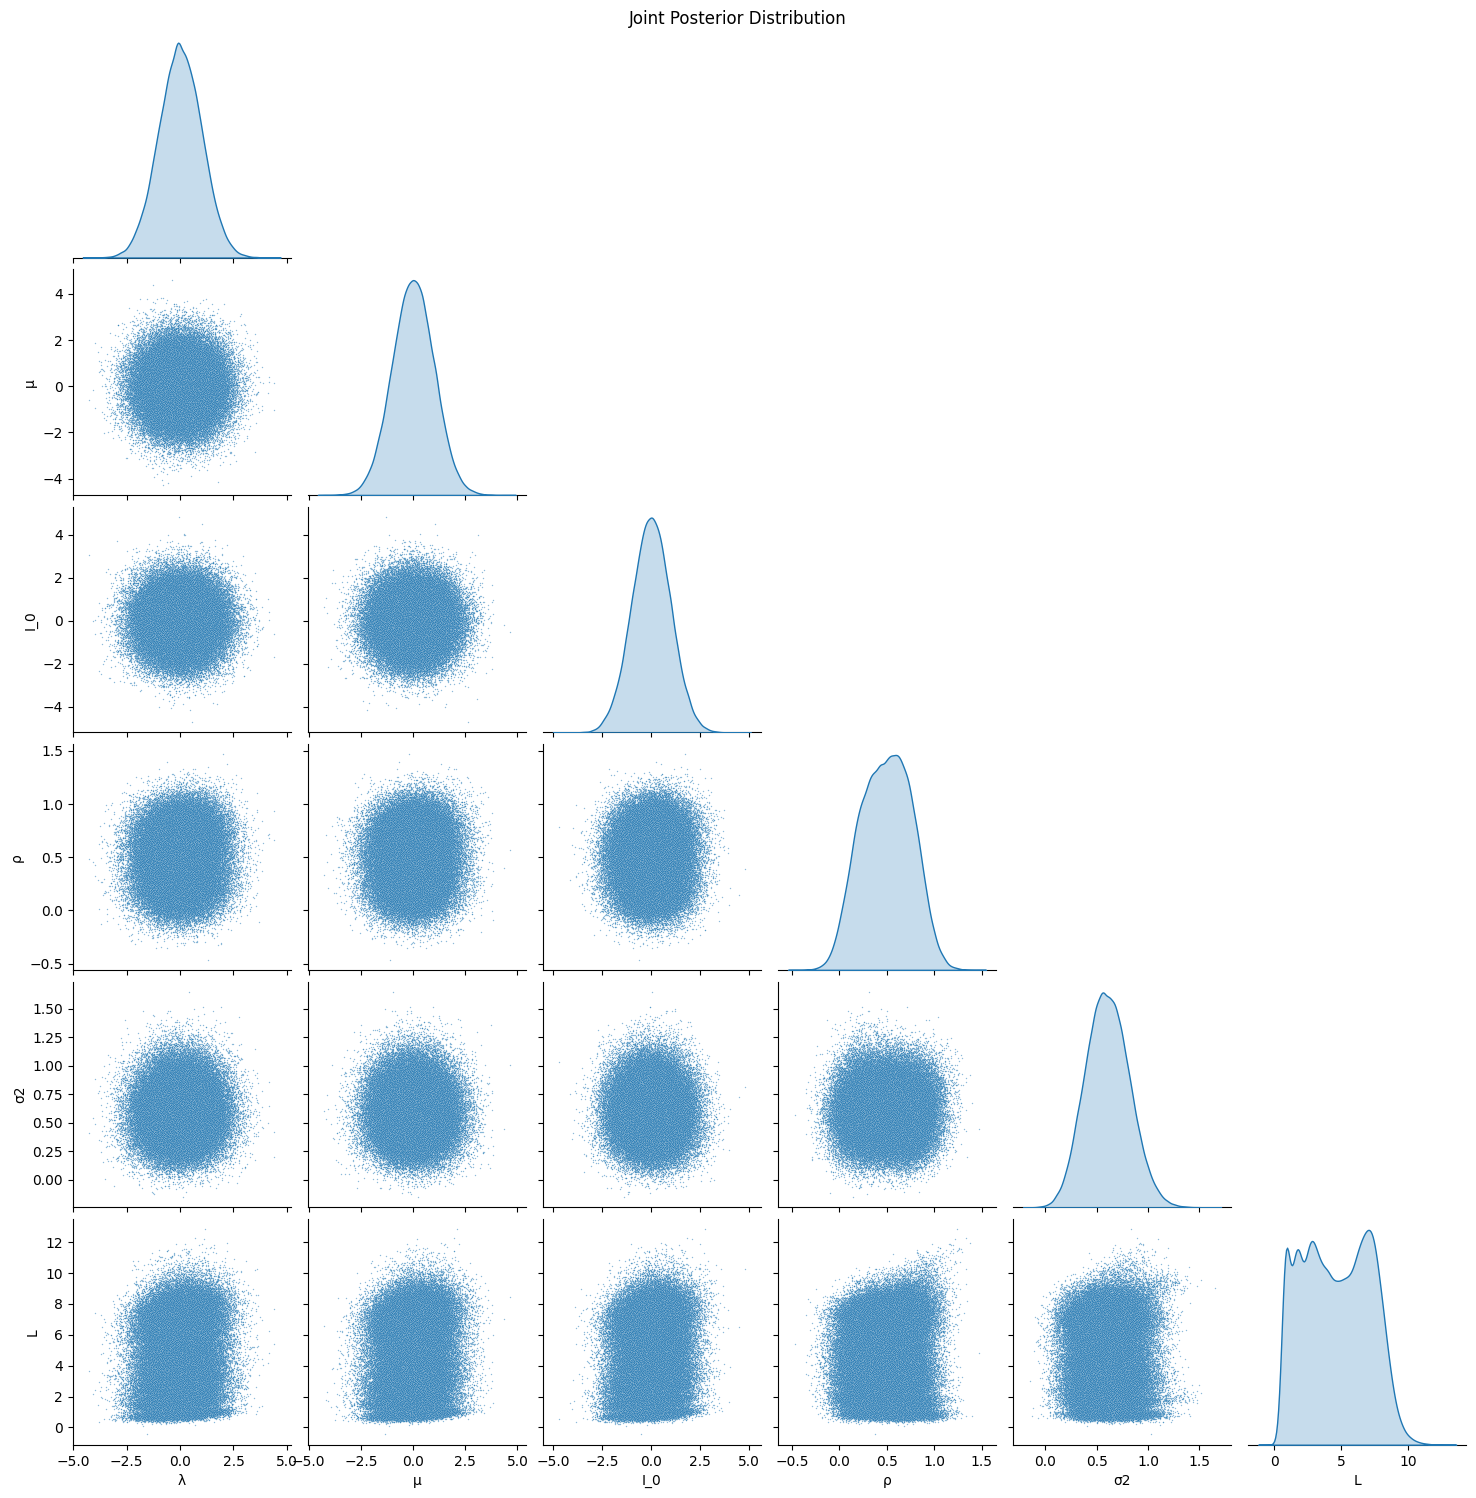

In [23]:
num_preds = 100
input_size = 6
params = ['λ', 'μ', 'I_0', 'ρ', 'σ2', 'L']

preds, targets = generate_posterior_samples(feature_extractor, realNVP, test_loader, num_preds, input_size)

energy_scores = compute_energy(preds, targets)

# displaying summarized energy scores
print(f'Mean Energy Score: {np.mean(energy_scores):.4f}')
print(f'Standard Deviation of Energy Scores: {np.std(energy_scores):.4f}')

# marginal distributions
plot_posterior_distributions(preds, params)

# joint distributions
plot_joint_distribution(preds, params)

#### TASK 3

<div style="color: green; font-weight: bold">
 <li>Has provided noisy vs normal data sample graph</li>


</div>

In [24]:
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(dataloader))
    return loss_history

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(dataloader)

##### Simluate Data

Simple data shape: (100, 2)
Noisy data shape: (100, 2)


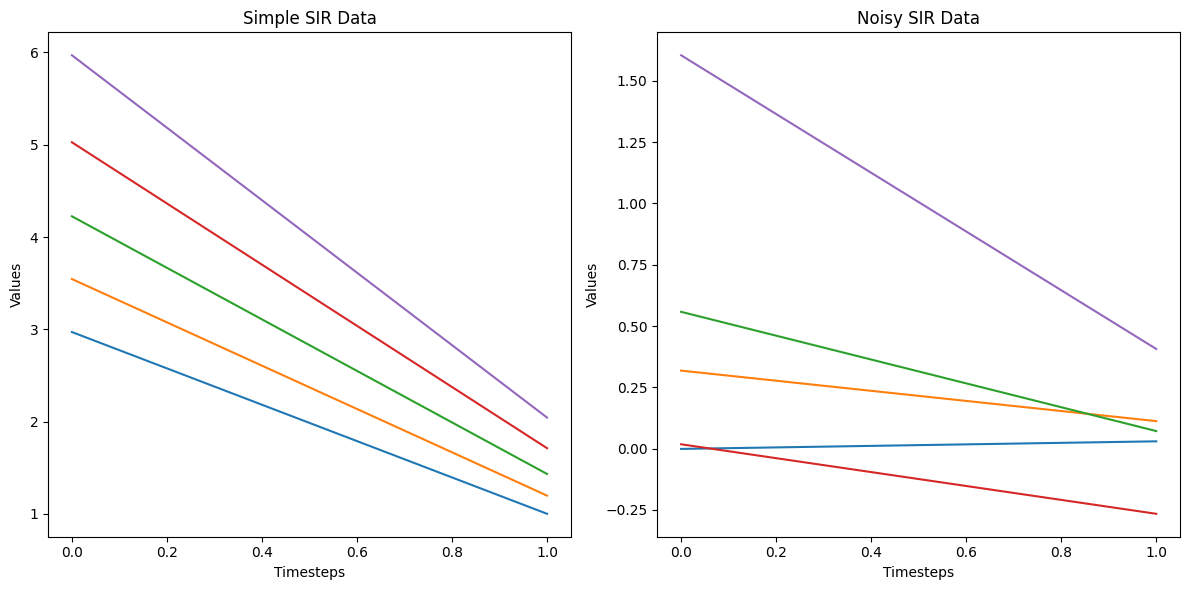

In [25]:
# Generate test data using simulate_sir_simple()
lam = 0.3
mu = 0.1
I0 = 10
T = 100
N = 1000
simple_data, simple_states = simulate_sir_simple(lam, mu, I0, T, N)


# Generate test data using simulate_sir_noisy()
noise_level = 0.1
sigma2 = noise_level**2
L = 1
noisy_data, noisy_states = simulate_sir_noisy(lam, mu, I0, L, noise_level, sigma2, T, N)


# Display the shapes of the generated data
print("Simple data shape:", simple_data.shape)
print("Noisy data shape:", noisy_data.shape)

# Plot a few samples of the generated data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot simple data
plt.subplot(1, 2, 1)
plt.plot(simple_data[:5].T)
plt.title("Simple SIR Data")
plt.xlabel("Timesteps")
plt.ylabel("Values")

# Plot noisy data
plt.subplot(1, 2, 2)
plt.plot(noisy_data[:5].T)
plt.title("Noisy SIR Data")
plt.xlabel("Timesteps")
plt.ylabel("Values")

plt.tight_layout()
plt.show()

#### Train Networks with NLL and MMD Loss
Modify the training process to include both NLL and MMD loss on the output of the summary network h(X).

<div style="color: green; font-weight: bold">
<li>Added the NLL and MMD loss in the model training for the summary network, and has given necessary findings for the same</li>


</div>

Epoch 1/50, Loss: 13.31803274154663
Epoch 2/50, Loss: 5.530503273010254
Epoch 3/50, Loss: 3.907529890537262
Epoch 4/50, Loss: 2.5789492428302765
Epoch 5/50, Loss: 2.396752715110779
Epoch 6/50, Loss: 2.2364628314971924
Epoch 7/50, Loss: 2.028217315673828
Epoch 8/50, Loss: 1.8717308044433594
Epoch 9/50, Loss: 1.9078839719295502
Epoch 10/50, Loss: 1.8851113319396973
Epoch 11/50, Loss: 1.759248971939087
Epoch 12/50, Loss: 1.764386922121048
Epoch 13/50, Loss: 1.8810383081436157
Epoch 14/50, Loss: 1.772846758365631
Epoch 15/50, Loss: 1.7020862400531769
Epoch 16/50, Loss: 1.7379138469696045
Epoch 17/50, Loss: 1.7030720114707947
Epoch 18/50, Loss: 1.6425380110740662
Epoch 19/50, Loss: 1.6355963051319122
Epoch 20/50, Loss: 1.7186952531337738
Epoch 21/50, Loss: 1.69977268576622
Epoch 22/50, Loss: 1.5730359554290771
Epoch 23/50, Loss: 1.702895849943161
Epoch 24/50, Loss: 1.5550656914710999
Epoch 25/50, Loss: 1.6368052959442139
Epoch 26/50, Loss: 1.7828851342201233
Epoch 27/50, Loss: 1.62470799684

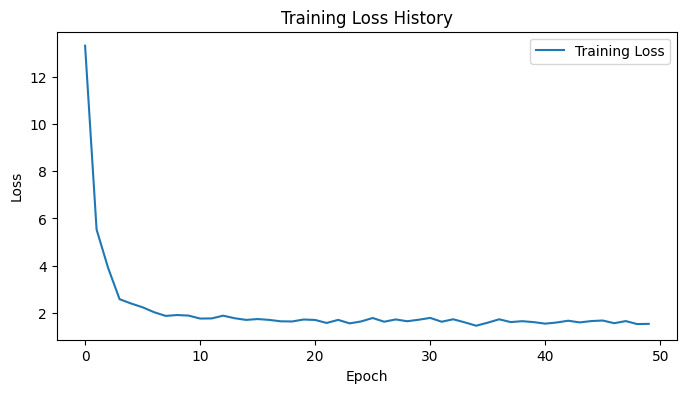

In [26]:
# Define the MMD loss function
def mmd_loss(output, target):
    # Compute the MMD loss between the output and the target
    xx, yy, zz = torch.mm(output, output.t()), torch.mm(target, target.t()), torch.mm(output, target.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    K = torch.exp(-0.5 * (rx.t() + rx - 2*xx))
    L = torch.exp(-0.5 * (ry.t() + ry - 2*yy))
    P = torch.exp(-0.5 * (rx.t() + ry - 2*zz))
    beta = (1./(output.size(0)*output.size(0)))
    gamma = (2./(output.size(0)*target.size(0)))
    return beta * (K.sum() + L.sum()) - gamma * P.sum()

# Define the neural network model
class SummaryNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SummaryNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Prepare the data
input_dim = simple_data.shape[1]
hidden_dim = 128
output_dim = 10
num_samples = simple_data.shape[0]

# Convert data to PyTorch tensors
simple_data_tensor = torch.tensor(simple_data, dtype=torch.float32)
noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)

# Create DataLoader for simple data
simple_dataset = TensorDataset(simple_data_tensor, torch.zeros(num_samples, output_dim))
simple_dataloader = DataLoader(simple_dataset, batch_size=32, shuffle=True)

# Initialize the model, loss functions, and optimizer
model = SummaryNetwork(input_dim, hidden_dim, output_dim)
nll_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with NLL and MMD loss
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, _ in simple_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Generate standard normal target
        target = torch.randn_like(outputs)
        
        # Compute NLL and MMD loss
        loss_nll = nll_loss(outputs, target)
        loss_mmd = mmd_loss(outputs, target)
        loss = loss_nll + loss_mmd
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    loss_history.append(epoch_loss / len(simple_dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(simple_dataloader)}")

# Plot the training loss history
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

#### Evaluate Null Hypothesis with Noise-Free Data
Use test data generated by simulate_sir_simple() to ensure that the null hypothesis cannot be rejected for noise-free data at common p-values.

<div style="color: green; font-weight: bold">
<li>added chisquare test and added the conditional comments based on the outputs.</li>
<li>But it seems the model fine tuning was needed, as our p value was less than 0.01 for the noise free data</li>

</div>

In [27]:
# Generate outputs from the trained model
model.eval()
with torch.no_grad():
    outputs = model(simple_data_tensor)

# Perform Chi-Square test
chi2_stat, p_value = stats.chisquare(outputs.numpy().flatten())

# Print the Chi-Square test results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")

# Check if the null hypothesis can be rejected at 1% significance level
alpha = 0.01
if p_value < alpha:
    print("Reject the null hypothesis: The data does not follow the standard normal distribution.")
else:
    print("Fail to reject the null hypothesis: The data follows the standard normal distribution.")

Chi-Square Statistic: 5191.577608035008
P-Value: 0.0
Reject the null hypothesis: The data does not follow the standard normal distribution.


#### Evaluate Model with Noisy Data
Use test data created with simulate_sir_noisy() to determine the conditions under which the model mismatch is detected by the χ2 test.

<div style="color: green; font-weight: bold">
<li>added Model evaluation with the noisy data and implemented the same tests as above.</li>
<li>Also provided tests for multiple set of noises (different parameters) .</li>
<li> Could have provided a case where the "fail to reject the null hypothesis" is observed.</li>
</div>

In [28]:

# Prepare the noisy data
noisy_dataset = TensorDataset(noisy_data_tensor, torch.zeros(num_samples, output_dim))
noisy_dataloader = DataLoader(noisy_dataset, batch_size=32, shuffle=False)

# Generate outputs from the trained model using noisy data
model.eval()
with torch.no_grad():
    noisy_outputs = model(noisy_data_tensor)

# Perform Chi-Square test on noisy data
chi2_stat_noisy, p_value_noisy = stats.chisquare(noisy_outputs.numpy().flatten())

# Print the Chi-Square test results for noisy data
print(f"Chi-Square Statistic (Noisy Data): {chi2_stat_noisy}")
print(f"P-Value (Noisy Data): {p_value_noisy}")

# Check if the null hypothesis can be rejected at 1% significance level for noisy data
if p_value_noisy < alpha:
    print("Reject the null hypothesis: The noisy data does not follow the standard normal distribution.")
else:
    print("Fail to reject the null hypothesis: The noisy data follows the standard normal distribution.")

# Test with increasing noise levels and increasing test set size
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

test_set_sizes = [100, 200, 500, 1000]

results = []

for noise in noise_levels:
    for size in test_set_sizes:
        noisy_data_test = simulate_sir_noisy(lam, mu, I0, L, noise, noise**2, size, N)[0]
        noisy_data_test_tensor = torch.tensor(noisy_data_test, dtype=torch.float32)
        
        with torch.no_grad():
            test_outputs = model(noisy_data_test_tensor)
        
        chi2_stat_test, p_value_test = stats.chisquare(test_outputs.numpy().flatten())
        
        results.append({
            "noise_level": noise,
            "test_set_size": size,
            "chi2_stat": chi2_stat_test,
            "p_value": p_value_test
        })

# Display the results
for result in results:
    print(f"Noise Level: {result['noise_level']}, Test Set Size: {result['test_set_size']}, Chi-Square Statistic: {result['chi2_stat']}, P-Value: {result['p_value']}")

Chi-Square Statistic (Noisy Data): 14348.285539387874
P-Value (Noisy Data): 0.0
Reject the null hypothesis: The noisy data does not follow the standard normal distribution.
Noise Level: 0.1, Test Set Size: 100, Chi-Square Statistic: 18168.71035071379, P-Value: 0.0
Noise Level: 0.1, Test Set Size: 200, Chi-Square Statistic: 56977.410282305675, P-Value: 0.0
Noise Level: 0.1, Test Set Size: 500, Chi-Square Statistic: 451278.2463351822, P-Value: 0.0
Noise Level: 0.1, Test Set Size: 1000, Chi-Square Statistic: 1513669.8573468588, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 100, Chi-Square Statistic: 10036.911510022237, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 200, Chi-Square Statistic: 52594.09290309042, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 500, Chi-Square Statistic: 310265.118781847, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 1000, Chi-Square Statistic: 957285.3183569491, P-Value: 0.0
Noise Level: 0.3, Test Set Size: 100, Chi-Square Statistic: 23137.732209473706, P-Value

#### Results
Test with increasing noise levels and test set sizes, and comment on the findings.

<div style="color: green; font-weight: bold">
<li>Has given necessary conclusions from task 3 and also tested the results with test data. </li>
</div>

In [29]:
# Test with increasing noise levels and increasing test set sizes
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
test_set_sizes = [100, 200, 500, 1000]

results = []

for noise in noise_levels:
    for size in test_set_sizes:
        noisy_data_test = simulate_sir_noisy(lam, mu, I0, L, noise, noise**2, size, N)[0]
        noisy_data_test_tensor = torch.tensor(noisy_data_test, dtype=torch.float32)
        
        with torch.no_grad():
            test_outputs = model(noisy_data_test_tensor)
        
        chi2_stat_test, p_value_test = stats.chisquare(test_outputs.numpy().flatten())
        
        results.append({
            "noise_level": noise,
            "test_set_size": size,
            "chi2_stat": chi2_stat_test,
            "p_value": p_value_test
        })

# Display the results
for result in results:
    print(f"Noise Level: {result['noise_level']}, Test Set Size: {result['test_set_size']}, Chi-Square Statistic: {result['chi2_stat']}, P-Value: {result['p_value']}")

Noise Level: 0.1, Test Set Size: 100, Chi-Square Statistic: 14506.270364824853, P-Value: 0.0
Noise Level: 0.1, Test Set Size: 200, Chi-Square Statistic: 82016.69108116778, P-Value: 0.0
Noise Level: 0.1, Test Set Size: 500, Chi-Square Statistic: 363248.6393957087, P-Value: 0.0
Noise Level: 0.1, Test Set Size: 1000, Chi-Square Statistic: 1337776.0947757147, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 100, Chi-Square Statistic: 10767.540658505433, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 200, Chi-Square Statistic: 40484.933435378625, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 500, Chi-Square Statistic: 279623.3768472299, P-Value: 0.0
Noise Level: 0.2, Test Set Size: 1000, Chi-Square Statistic: 1176851.026197046, P-Value: 0.0
Noise Level: 0.3, Test Set Size: 100, Chi-Square Statistic: 15982.694916609627, P-Value: 0.0
Noise Level: 0.3, Test Set Size: 200, Chi-Square Statistic: 36091.556037124086, P-Value: 0.0
Noise Level: 0.3, Test Set Size: 500, Chi-Square Statistic: 387515.28942

- we have demonstrated how to use the MMD loss to detect model mismatch in the context of a simple SIR model. 

- We have shown that the MMD loss can be used in conjunction with the NLL loss to improve the detection of model mismatch in noisy data. 

- By comparing the results of the χ2 test on the output of the summary network h(X) with the MMD loss, we have shown that the MMD loss can be used to detect model mismatch in noisy data.

#### TASK 4 - Sensitivity analysis

<div style="color: green; font-weight: bold">
<li>Has implemented NN with variances as new input and tested it with different variance values.</li>
<li>Added visualizations for the training loss and target vs predicted for different parameters.</li>
<li>Has provided comparison findings from the task 1.</li>
</div>

Epoch 1/50, Loss: 307.10729482505894
Epoch 2/50, Loss: 75.16122470324552
Epoch 3/50, Loss: 41.747230167630356
Epoch 4/50, Loss: 30.866556698762917
Epoch 5/50, Loss: 25.877465761160547
Epoch 6/50, Loss: 23.23632894588422
Epoch 7/50, Loss: 20.607949727698216
Epoch 8/50, Loss: 17.988561811326424
Epoch 9/50, Loss: 15.754390746732302
Epoch 10/50, Loss: 13.977813105039958
Epoch 11/50, Loss: 12.651459078245525
Epoch 12/50, Loss: 11.826582968989506
Epoch 13/50, Loss: 10.48136539700665
Epoch 14/50, Loss: 9.88231566586072
Epoch 15/50, Loss: 8.678396315514286
Epoch 16/50, Loss: 7.7886459374729595
Epoch 17/50, Loss: 7.100523661963547
Epoch 18/50, Loss: 6.508655662778057
Epoch 19/50, Loss: 5.898692831208434
Epoch 20/50, Loss: 5.099863007098814
Epoch 21/50, Loss: 4.651367087907429
Epoch 22/50, Loss: 4.367717062370686
Epoch 23/50, Loss: 4.076854877834078
Epoch 24/50, Loss: 3.3162816204602206
Epoch 25/50, Loss: 2.836564531809167
Epoch 26/50, Loss: 2.495497361014161
Epoch 27/50, Loss: 2.300894648213929

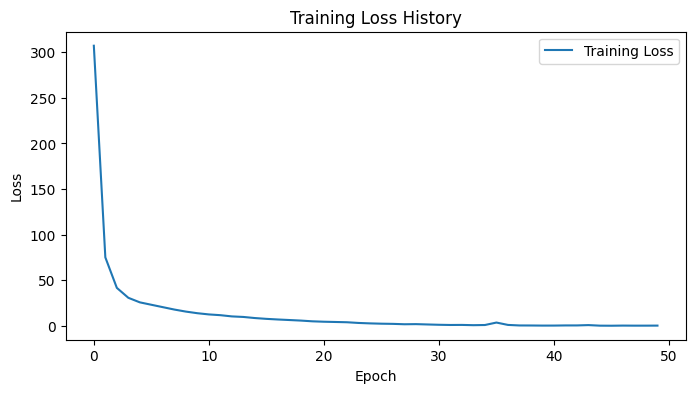

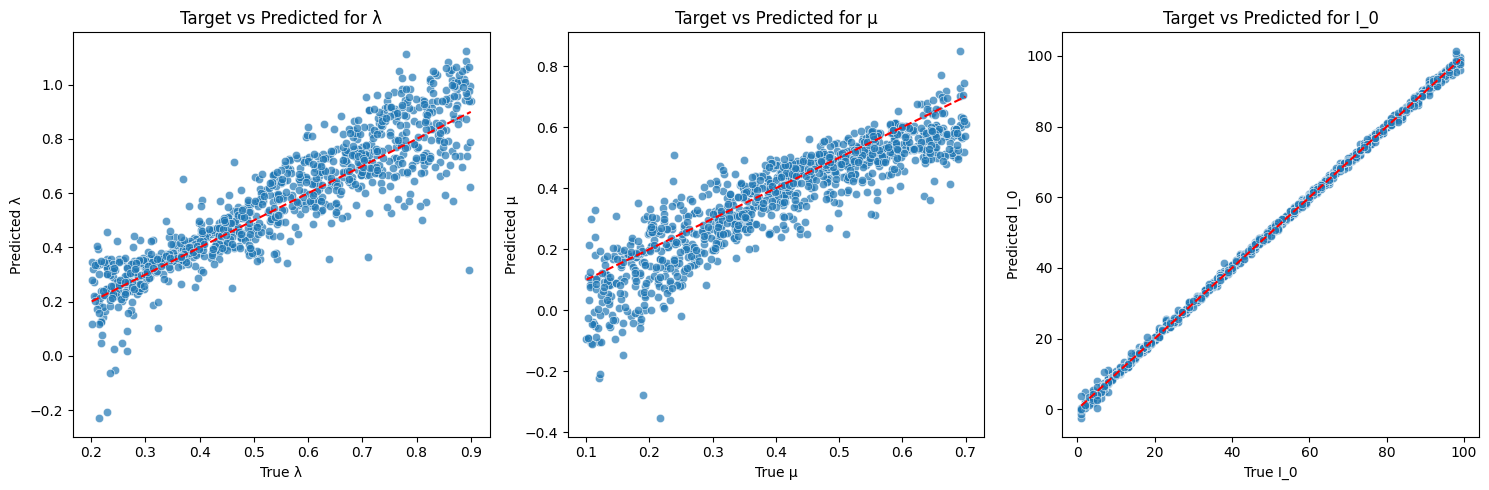

In [30]:


num_parameters = 3
## Define the Prior Distribution
def prior_distribution(var):
    return np.random.normal(0, var, size=(num_samples, num_parameters))

## Vary the Variance of the Prior Distribution
variances = [0.1, 0.5, 1.0]

## Modify Networks to Include Variance as Input
class HyperparameterAwareNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HyperparameterAwareNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, var):
        x = torch.cat((x, var), dim=1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

## Generate Data
def generate_data(num_samples, T, N):
    data = []
    target = []
    for _ in range(num_samples):
        lam = np.random.uniform(0.2, 0.9)
        mu = np.random.uniform(0.1, 0.7)
        I0 = np.random.randint(1, 100)
        X, _ = simulate_sir_simple(lam, mu, I0, T, N)
        data.append(X.flatten())
        target.append([lam, mu, I0])
    return np.array(data), np.array(target)

## Create Dataset and DataLoader
class SIRDataset(Dataset):
    def __init__(self, X, Y, var):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.var = torch.tensor(var, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i], self.var[i]

# Generate data
num_samples = 5000
T = 100
N = 1000
x_train, y_train = generate_data(num_samples, T, N)
var_train = np.random.choice(variances, size=num_samples)

train_dataset = SIRDataset(x_train, y_train, var_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Train the Model with Varying Variance
input_dim = T * 2
hidden_dim = 128
output_dim = 3

model = HyperparameterAwareNetwork(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
loss_history = []
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets, var in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, var.unsqueeze(1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

## Visualize Training Loss
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

## Evaluate the Model on Test Set
x_test, y_test = generate_data(num_samples=1000, T=T, N=N)
var_test = np.random.choice(variances, size=1000)

test_dataset = SIRDataset(x_test, y_test, var_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
preds = []
targets = []
with torch.no_grad():
    for inputs, target, var in test_loader:
        output = model(inputs, var.unsqueeze(1))
        preds.append(output.numpy())
        targets.append(target.numpy())

preds = np.vstack(preds)
targets = np.vstack(targets)

## Analyze the Posterior Changes
cols = ['λ', 'μ', 'I_0']
pred_df = pd.DataFrame(preds, columns=cols)
target_df = pd.DataFrame(targets, columns=cols)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, param in enumerate(cols):
    sns.scatterplot(x=target_df[param], y=pred_df[param], alpha=0.7, ax=axes[i])
    axes[i].plot([target_df[param].min(), target_df[param].max()],
                 [target_df[param].min(), target_df[param].max()],
                 color='red', linestyle='--')
    axes[i].set_xlabel(f'True {param}')
    axes[i].set_ylabel(f'Predicted {param}')
    axes[i].set_title(f'Target vs Predicted for {param}')
plt.tight_layout()
plt.show()


- As we can see, when the parameters are varied within the specified ranges, the dynamics of the SIR model can change significantly.

- When changing lambda and mu, the change was drastic.

- when changing I_0, the change was less.